# Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.23.0 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load HSC and endothelium from DS-FBM and non-DS FBM

# Import the FBM HSC and endo

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [4]:
adata.shape

(103228, 33712)

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [6]:
from scipy import sparse
array_vals = adata.X
adata.X = sparse.csr_matrix(adata.X)
adata.raw = adata
adata.X = array_vals

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'sinusoidal EC',  
                                            'proliferating EC', 'tip EC'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                  92
proliferating EC     26
sinusoidal EC       550
tip EC              362
dtype: int64

In [9]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].replace(["proliferating EC", "sinusoidal EC", 
                                                             "tip EC"], ["endothelium", "endothelium", 
                                                                        "endothelium"])

In [10]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC             92
endothelium    938
dtype: int64

In [11]:
adata.obs["dataset"] = "fbm"

In [12]:
fbm = adata

# Import the DS HSC and endo

In [13]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/fbm_ds_cite_seq/data/fbm_ds_citeseq_plus_scrna_forMS_20210119.h5ad')

In [14]:
adata.shape

(16743, 33694)

In [15]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                 181
CD14 monocyte              320
CD56 bright NK              79
CMP                         50
DC1                         45
DC2                        228
DC3                        108
HSC                        105
ILC precursor               13
MEMP                       130
MK                          83
MOP                        422
MSC                         53
Treg                         8
chondrocyte                  4
early B cell                42
early MK                    34
early erythroid           1348
endothelium                111
eo/baso/mast precursor      53
eosinophil                  63
late erythroid            6336
macrophage                 113
mast cell                   39
mast cell                   27
mature B cell               31
mature NK                  147
mid erythroid             5230
myelocyte                  243
neutrophil                 273
osteoblast                 

In [16]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'endothelium'])].copy()

In [17]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC            105
endothelium    111
dtype: int64

In [18]:
adata.obs["dataset"] = "ds_fbm"
ds_fbm = adata

# Combine the datasets

In [19]:
from scipy import sparse

objects = [ds_fbm, fbm]

for i in objects:
    array_vals = i.X
    i.X = sparse.csr_matrix(i.X)
    i.raw = i
    i.X = array_vals

In [20]:
merged = fbm.concatenate(ds_fbm, index_unique=None, join='inner')

In [21]:
merged.shape

(1246, 33694)

In [22]:
cell_numbers = merged.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC             197
endothelium    1049
dtype: int64

In [23]:
merged.obs["dataset_cell.labels"] = merged.obs["dataset"].astype(str) + '_' + merged.obs["cell.labels"].astype(str)

In [24]:
cell_numbers = merged.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_HSC            105
ds_fbm_endothelium    111
fbm_HSC                92
fbm_endothelium       938
dtype: int64

# Pre-process the data

In [25]:
adata=merged

In [26]:
# normalise count data 
sc.pp.normalize_total(adata)

In [27]:
# log the count data 
sc.pp.log1p(adata)

In [28]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [29]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Run violin plots for HSC

In [30]:
cell_numbers = adata.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_HSC            105
ds_fbm_endothelium    111
fbm_HSC                92
fbm_endothelium       938
dtype: int64

In [31]:
hsc_genes=["NRP2", "ESAM", "FGFR1", "NOTCH1", "TNFRSF10C", "KRT19", "CD44", "NOTCH2", "KRT19", "NRP2", "KRT19", 
          "FZD6", "PLAUR", "SELL", "KIT", "MERTK", "KRT19", "CD46", "FLT3", "JAM3", "KRT19"]

... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
...

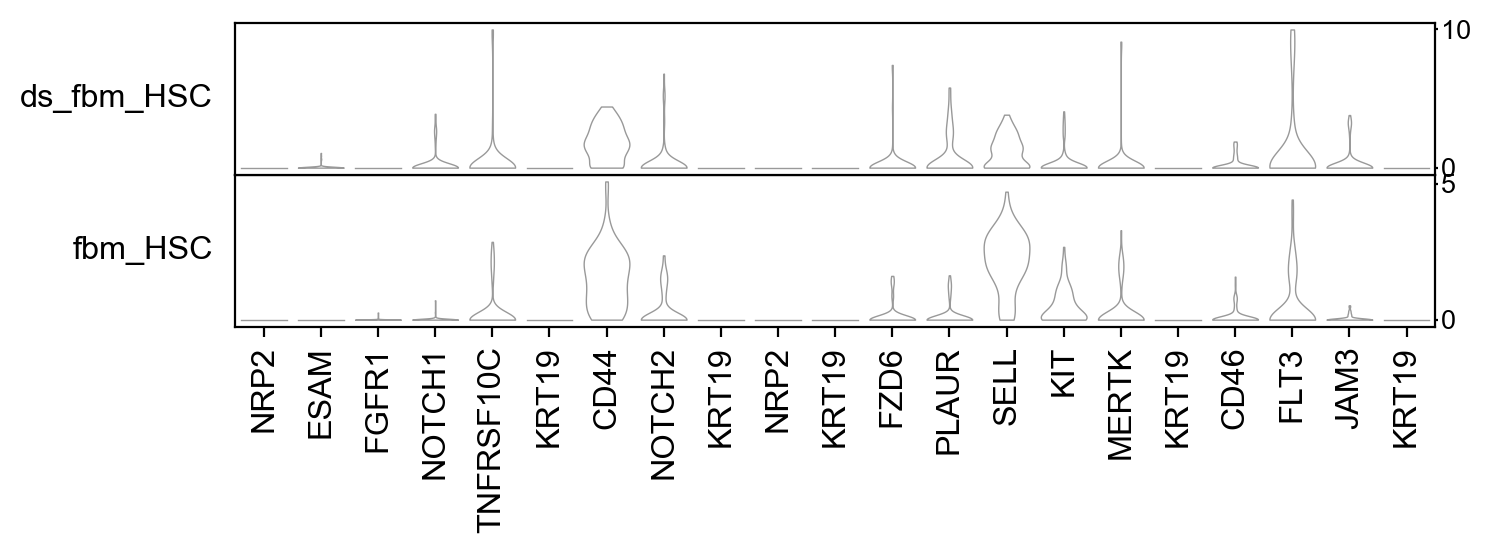

In [32]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].astype("category")

subset = adata[adata.obs['dataset_cell.labels'].isin(['ds_fbm_HSC', 'fbm_HSC'])].copy()

subset.obs["dataset_cell.labels"] = subset.obs["dataset_cell.labels"].cat.reorder_categories(
    ['ds_fbm_HSC', 'fbm_HSC'])

sc.pl.stacked_violin(subset, var_names=hsc_genes, save="hsc_ds_nonds_fbm_violin_20210204.pdf", 
                     rotation=90, 
                     groupby='dataset_cell.labels', use_raw=False, swap_axes=False, figsize=(8,2), 
                     row_palette=["#ffffff", "#ffffff"])

In [33]:
subset = adata[:, hsc_genes].copy()

sc.tl.rank_genes_groups(subset, groupby='dataset_cell.labels', method='wilcoxon', use_raw=False, 
                        log_transformed=True, groups=['ds_fbm_HSC', 'fbm_HSC'], n_genes=subset.shape[1])

# save df for filtered degs
result = subset.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/fig6e_hsc_ds_nonds_fbm_violin_degs_20210204.csv")
degs_by_cluster

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storin

,ds_fbm_HSC_names,ds_fbm_HSC_logfold,ds_fbm_HSC_pvals,ds_fbm_HSC_pvals_a,fbm_HSC_names,fbm_HSC_logfold,fbm_HSC_pvals,fbm_HSC_pvals_a
0,CD44,4.480328,4.465196e-34,9.376912e-33,SELL,4.898363,1.454528e-41,3.054509e-40
1,SELL,2.697964,2.301778e-17,8.056224e-17,CD44,3.669870,1.382925e-31,1.452071e-30
2,FLT3,5.747172,3.097128e-06,8.129961e-06,KIT,0.525058,1.404116e-06,3.276271e-06
3,PLAUR,2.146525,4.444187e-04,8.484356e-04,FLT3,2.630980,1.913294e-04,3.652651e-04
4,NOTCH2,1.428390,8.522038e-02,1.491357e-01,NOTCH2,1.016312,4.454929e-03,7.796127e-03
5,TNFRSF10C,1.135217,3.362402e-01,5.043603e-01,MERTK,0.538279,2.254785e-01,3.642345e-01
6,KRT19,-23.069525,9.881286e-01,9.881286e-01,TNFRSF10C,0.361121,3.181183e-01,4.771774e-01
7,KRT19,-23.069525,9.881286e-01,9.881286e-01,PLAUR,-1.140987,9.522257e-01,9.889505e-01
8,KRT19,-23.069525,9.881286e-01,9.881286e-01,KRT19,-23.053108,9.889505e-01,9.889505e-01
9,KRT19,-23.069525,9.881286e-01,9.881286e-01,KRT19,-23.053108,9.889505e-01,9.889505e-01


# Run violin plots for endo

In [34]:
cell_numbers = adata.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_HSC            105
ds_fbm_endothelium    111
fbm_HSC                92
fbm_endothelium       938
dtype: int64

In [35]:
endo_genes=["PGF", "ESAM", "FGF7", "DLK1", "TNFSF10", "NOV", "SELE", "DLL4", "SEMA3F", "VEGFA", "HBEGF", 
           "WNT5A", "ITGA4", "CD34", "KITLG", "GAS6", "JAG2", "JAG1", "FLT3LG", "JAM3", "FGFR2"]

... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
...

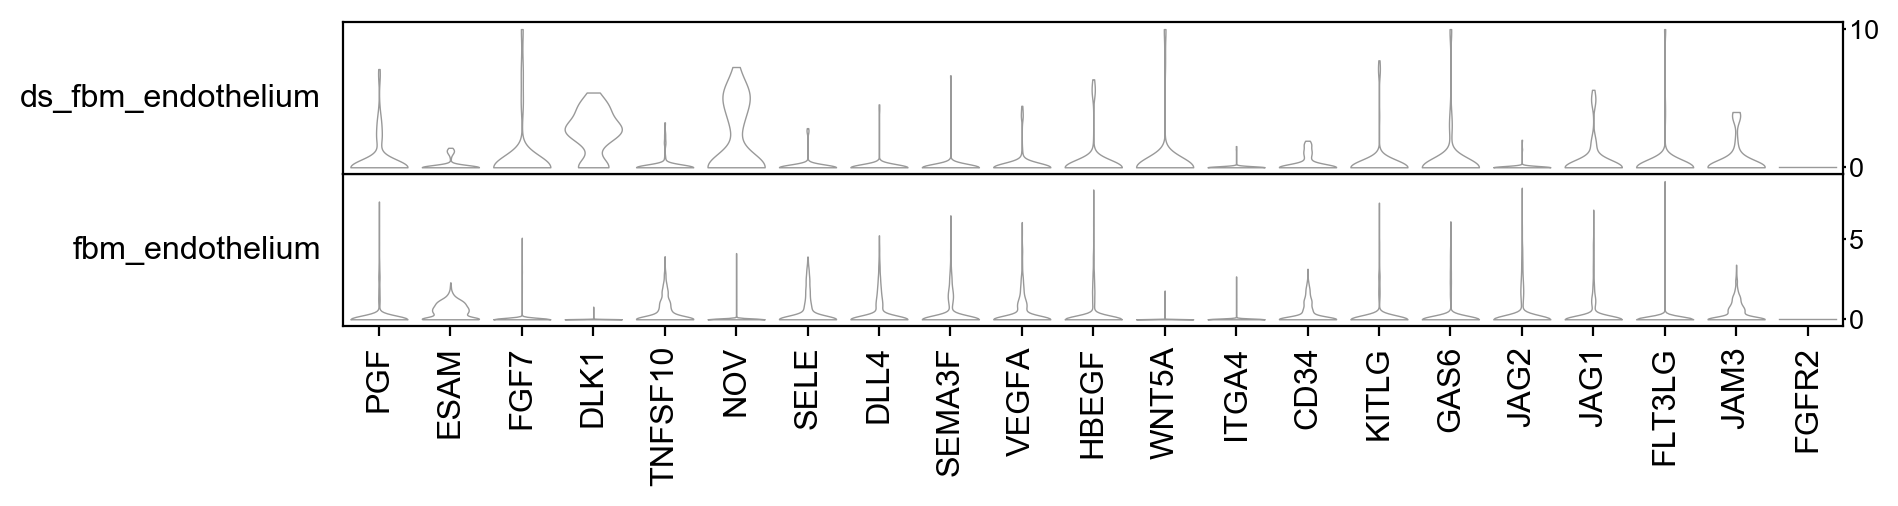

In [36]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].astype("category")

subset = adata[adata.obs['dataset_cell.labels'].isin(['ds_fbm_endothelium', 'fbm_endothelium'])].copy()

subset.obs["dataset_cell.labels"] = subset.obs["dataset_cell.labels"].cat.reorder_categories(
    ['ds_fbm_endothelium', 'fbm_endothelium'])

sc.pl.stacked_violin(subset, var_names=endo_genes, save="endo_ds_nonds_fbm_violin_20210204.pdf", 
                     rotation=90, 
                     groupby='dataset_cell.labels', use_raw=False, swap_axes=False, figsize=(10,2), 
                     row_palette=["#ffffff", "#ffffff"])

In [37]:
subset = adata[:, endo_genes].copy()

sc.tl.rank_genes_groups(subset, groupby='dataset_cell.labels', method='wilcoxon', use_raw=False, 
                        log_transformed=True, groups=['ds_fbm_endothelium', 'fbm_endothelium'], 
                        n_genes=subset.shape[1])

# save df for filtered degs
result = subset.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/fig6e_endo_ds_nonds_fbm_violin_degs_20210204.csv")
degs_by_cluster

... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
...

,ds_fbm_endothelium_names,ds_fbm_endothelium_logfold,ds_fbm_endothelium_pvals,ds_fbm_endothelium_pvals_a,fbm_endothelium_names,fbm_endothelium_logfold,fbm_endothelium_pvals,fbm_endothelium_pvals_a
0,DLK1,6.862011e+00,9.679014e-40,2.032593e-38,ESAM,3.265514e+00,2.832840e-68,5.948963e-67
1,NOV,8.776180e+00,3.803333e-14,3.993499e-13,SELE,4.003199e+00,5.519237e-18,2.897600e-17
2,PGF,1.668372e+00,8.794550e-02,1.420658e-01,VEGFA,2.813198e+00,2.778445e-15,1.166947e-14
3,FGF7,4.089147e+00,1.518178e-01,2.277268e-01,DLL4,4.283809e+00,1.225454e-13,4.289091e-13
4,WNT5A,8.315103e+00,4.415581e-01,5.661338e-01,JAM3,5.400217e-01,8.076016e-13,2.422805e-12
5,JAG1,1.054371e+00,4.582988e-01,5.661338e-01,TNFSF10,1.451703e+00,7.709415e-12,2.023721e-11
6,GAS6,1.312309e+00,7.741009e-01,8.555852e-01,SEMA3F,4.651551e+00,4.811555e-09,1.122696e-08
7,FLT3LG,1.190369e+00,8.952276e-01,9.399889e-01,JAG2,5.482605e+00,3.484140e-05,7.316693e-05
8,FGFR2,4.080220e-08,1.000000e+00,1.000000e+00,JAG1,7.734292e-01,1.865578e-02,3.013626e-02
9,KITLG,4.260168e-01,6.080822e-01,7.094292e-01,KITLG,1.496655e+00,4.437807e-02,6.656710e-02


# Save the data

In [38]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [39]:
adata.X

<1246x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 3174446 stored elements in Compressed Sparse Row format>

In [40]:
adata.raw.X

<1246x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 3521757 stored elements in Compressed Sparse Row format>

In [41]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/figs6e_fbm_ds_hsc_endo_violin_20210204.h5ad")

... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
...